<a href="https://colab.research.google.com/github/ddiaz99/Analog-Order-Filters-Thesis/blob/main/AnalogOrderFilters_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <strong> Piecewise linear signals for analog order filters </strong>
> Undergraduate thesis in Electronic Engineering
-----
-----
<h5 align=center> ${\text{Developed by:}}$ <h5>

<h3 align=center> ${\text{Diego Fernando Diaz Padilla}}$ <h3>

<h6 align=center> ${\small\texttt{di-diego@javeriana.edu.co}}$ <h6>

#####<h6 align=center> 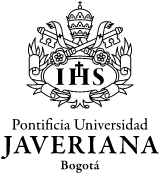 <h6>










In the following notebook we present the practical development of the undergraduate thesis *piecewise linear signals for analog order filters*. We developed the following algorithms:

1.   Monotone rearrangement of piecewise linear signals.
2.   Window and functional (rank) operators.
3.   Moving window method for analog rank order filters.
4.   Analog rank order filters by vertex calculation.



In [1]:
import matplotlib.pyplot as plt
import matplotlib.markers
import numpy as np
import random
from numpy.testing import assert_almost_equal
from statistics import mean 
from math import isclose
import math
import time

## **1. PL Rearrangement algorithm and test protocol**
The monotone rearrangement algorithm for piecewise linear (PL) signals with its respective verification protocol is presented below. Recall that for a signal $f\colon I\to \mathbb{R}$ the distribution function is defined by: $$T_{f}(y):= \mu\{ t\in I\colon f(t)\leq y \}, \:\: ∀ y\in [\inf f, \sup f].$$ And the rearrangement by: $$f^{\ast}(t):= \inf \{y \in [\inf f, \sup f]\colon T_{f}(y)\geq t\}, \:\: ∀ t\in [0,\mu(I)]$$

### **1.1 PL Rearrangement algorithm**

The following algorithm computes the ordered vertices given the input vertices $\{(x_{i},y_{i})\}_{i=1}^{n}$ of a piecewise linear signals $f$.
The algorithm has the following steps:
*   Compute measures between vertical leves (without repeating any level), i.e., it computes the values $\mu(f^{-1}(y_{i-1},y_{i}] )$ and  $\mu(f^{-1}(\{y_{1}\}) )$.
*   Compute $x$-components of ordered vertices as: $$x_{j} = T_{f}(y_{j}) = \sum_{k=1}^{j}\mu(f^{-1}(y_{k-1},y_{k}] ) + \mu(f^{-1}(\{y_{1}\}) ).$$ If there are constant segments then we add: $$x_{j-1} = T_f(y_{j}) - \mu(f^{-1}(\{y_{j}\}) )$$
*   Compute $y$-components of ordered vertices; it is sufficient to add the same vertical levels.

The function returns the $x$ and $y$ components of the ordered vertices and also the measure between levels of the rearrangement.




In [2]:
def PL_Rearrangement(x,y):
  
  """
  Args:
    x: list of x-components of piecewise linear function (ordered)
    y: list of corresponding y-components of piecewise linear signal

  Returns:
    x_ast: list of x-components of the rearrangement signal (ordered)
    y_ast: list of corresponding y-components of the rearrangement signal
    vec_meas: list with the measure between vertical levels
  """

  # Vertical levels are stored in P_prime
  P_prime = np.copy(y)
  P_prime.sort()
  P_prime = np.unique(P_prime, axis=0)

  # vec_inv_mea for constant intervals and vec_meas for vertical intervals measure
  vec_inv_mea = [0] * len(P_prime)
  vec_meas = [0] * (len(P_prime)-1)

  # Pairs like (x1,y1),(x2,y2),..,(xn,yn)
  s = list(zip(x,y))
  j = 0

  # calculate if first level is constant
  for v_1,v_2 in zip(s, s[1:]): # for each pair of consecutive vertices
      if (v_1[1] == v_2[1] == P_prime[0]) and (v_1[0] != v_2[0]): # if there is a constant interval
        vec_inv_mea[0] += (v_2[0]-v_1[0]) # save in vec_inv_mea the measure
      else:
        continue

  # calculate measure between levels
  for y_iprime,y_i1prime in zip(P_prime,P_prime[1:]): # for each pair of vertical levels
    for v_1,v_2 in zip(s, s[1:]): # for each pair of consecutive vertices
      if (((v_1[1]>=y_i1prime) and (v_2[1]<=y_iprime)) or ((v_1[1]<=y_iprime) and (v_2[1]>=y_i1prime))) and (v_1[0] != v_2[0]): # if line intersects partition
        m_i = (v_2[1]-v_1[1])/(v_2[0]-v_1[0]) # calculate slope of line
        b_i = ((-m_i) * v_1[0]) + v_1[1] # calculate y-intercept of line
        vec_meas[j] += abs((y_iprime-b_i)/(m_i) -((y_i1prime-b_i)/m_i)) # add measure to vec_meas

      elif (v_1[1] == v_2[1] == y_i1prime) and (v_1[0] != v_2[0]): # if there is a constant interval
        vec_meas[j] += (v_2[0]-v_1[0]) # add measure to vec_meas
        vec_inv_mea[list(P_prime).index(y_i1prime)] += (v_2[0]-v_1[0]) # add to vec_inv_mea

      else:
        continue

    j += 1

  # x and y components of ordered vertices
  x_ast = []
  y_ast = []

  # constant values in f_ast
  constants_f_ast = []

  #calculate x-components of ordered vertices
  for i in range(len(P_prime)): #for each vertical level
    T = 0
    for k in range(i):
      T += vec_meas[k] # sum measures between vertical levels up until the i-level
    
    T += vec_inv_mea[0] # sum measure of first level if there is any
    x_ast.append(T) # add x-component to x_ast

    if vec_inv_mea[i] != 0: # if this i-level has a constant interval
      constants_f_ast.append(i) # add the index i to constants_f_ast
      T = T - vec_inv_mea[i] # calculate de x-component
      x_ast.append(T) # add x-component to x_ast
      constants_f_ast.append(None) 
    else:
      constants_f_ast.append(None)

  x_ast.sort() # sort list x_ast

  # calculate y-components of ordered vertices
  y_ast = list(P_prime)
  j = 0
  for i in range(len(y_ast)):
    if constants_f_ast[j] != None:  # if there is a constant interval in f_ast
      y_ast.append(list(P_prime)[constants_f_ast[j]]) # add same level 
      j+=2
    else:
      j+=1

  y_ast.sort()

  return x_ast,y_ast,vec_meas

#### **1.1.1 Test the algorithm with piecewise linear signals**

In the following cell you can enter the vertices of a piecewise linear signal and it will plot the monotone rearrangement; the input vertices need to be ordered in the $x$-componente, i.e., $x_i \leq x_{i+1}$ for all $i$.

Enter the x-components ordered and separated by commas: -2,0,2,2,3,5,5,6,8,8.5,11,11,13
Enter the y-components corresponding to the x-components, separated by commas: -1,1,1,2,4,4,7,4,4,3,6,1,1


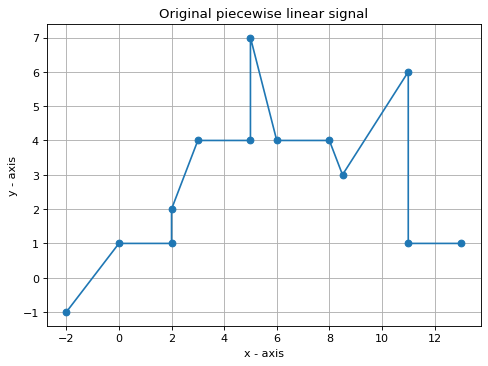

Original vertices:  [(-2.0, -1.0), (0.0, 1.0), (2.0, 1.0), (2.0, 2.0), (3.0, 4.0), (5.0, 4.0), (5.0, 7.0), (6.0, 4.0), (8.0, 4.0), (8.5, 3.0), (11.0, 6.0), (11.0, 1.0), (13.0, 1.0)]
--- 0.0006322860717773438 seconds ---


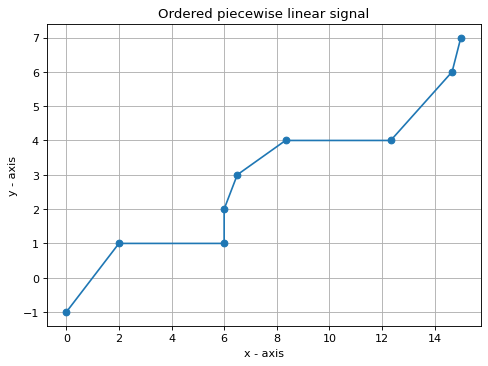

Ordered vertices:  [(0, -1.0), (2.0, 1.0), (6.0, 1.0), (6.0, 2.0), (6.5, 3.0), (8.333333333333334, 4.0), (12.333333333333334, 4.0), (14.666666666666668, 6.0), (15.0, 7.0)]


In [ ]:
x = np.array([float(i) for i in input('Enter the x-components ordered and separated by commas: ').split(',')])
x.sort()
y = np.array([float(i) for i in input('Enter the y-components corresponding to the x-components, separated by commas: ').split(',')])

plt.figure(figsize=(7,5),dpi=80)
plt.plot(x, y,marker='o')
plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title('Original piecewise linear signal')
plt.grid(b = True)
plt.show()
print('Original vertices: ', list(zip(x,y)))

start_time = time.time()
x_ast,y_ast,vec_meas = PL_Rearrangement(x,y)
print("--- %s seconds ---" % (time.time() - start_time)) # strat counting time

plt.figure(figsize=(7,5),dpi=80)
plt.plot(x_ast, y_ast,marker='o')
plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title('Ordered piecewise linear signal')
plt.grid(b = True)
plt.show()

print('Ordered vertices: ', list(zip(x_ast,y_ast)))

### **1.2 Test protocol algorithm**

Now we introduce the test protocol for the PL-Rearrangement algorithm. Two verify that a list of vertices corresponds to the rearrangement of an input list of vertices we need to compute the measure between vertical levels and check that they are the same; this method is enough because there is only one left-continuous rearrangement equimeasurable with the original signals.

We will verify this with random signals.

* The **inputs** for this function is the *vec_meas* list, which has the measures between levels of the original function, and the *x* and *y* components of the ordered vertices. 

* The **output** of the function is the maximum and the average difference between corresponding measures.

In [3]:
def check_rearrangement(vec_meas,x_ast,y_ast):

  """
  Args:
    vec_meas: list with the measure between vertical levels
    x_ast: list of x-components of the rearrangement signal (ordered)
    y_ast: list of corresponding y-components of the rearrangement signal
    
  Returns:
    max_difference: returns the maximum difference of corresponding measures
    average_difference: returns the average difference of corresponding measures
  """

  # Vertical levels are stored in P_prime
  P_prime1 = np.copy(y_ast)
  P_prime1.sort()
  P_prime1 = np.unique(P_prime1, axis=0)

  # vec_inv_mea for constant intervals and vec_meas for vertical intervals measure
  vec_inv_meaO = [0] * len(P_prime1)
  vec_measO = [0] * (len(P_prime1)-1)

  # Pairs like (x1,y1),(x2,y2),..,(xn,yn)
  s = list(zip(x_ast,y_ast))
  j = 0

  # calculate if first level is constant
  for v_1,v_2 in zip(s, s[1:]): # for each pair of consecutive vertices
      if (v_1[1] == v_2[1] == P_prime1[0]) and (v_1[0] != v_2[0]): # if there is a constant interval
        vec_inv_meaO[0] += (v_2[0]-v_1[0]) # save in vec_inv_mea the measure
      else:
        continue

  # calculate measure between levels
  for y_iprime,y_i1prime in zip(P_prime1,P_prime1[1:]): # for each pair of vertical levels
    for v_1,v_2 in zip(s, s[1:]): # for each pair of consecutive vertices
      if (((v_1[1]>=y_i1prime) and (v_2[1]<=y_iprime)) or ((v_1[1]<=y_iprime) and (v_2[1]>=y_i1prime))) and (v_1[0] != v_2[0]): # if line intersects partition
        m_i = (v_2[1]-v_1[1])/(v_2[0]-v_1[0]) # calculate slope of line
        b_i = ((-m_i) * v_1[0]) + v_1[1] # calculate y-intercept of line
        vec_measO[j] += abs((y_iprime-b_i)/(m_i) -((y_i1prime-b_i)/m_i)) # add measure to vec_meas

      elif (v_1[1] == v_2[1] == y_i1prime) and (v_1[0] != v_2[0]): # if there is a constant interval
        vec_measO[j] += (v_2[0]-v_1[0]) # add measure to vec_meas
        vec_inv_meaO[list(P_prime1).index(y_i1prime)] += (v_2[0]-v_1[0]) # add to vec_inv_mea

      else:
        continue

    j += 1

  # compare corresponding measures and take maximum difference
  difference = []
  for i in range(len(vec_measO)):
    difference.append(abs(vec_measO[i] - vec_meas[i]))

  max_difference = max(difference)
  average_difference = mean(difference)
  std_difference = np.std(difference)

  return max_difference,average_difference,std_difference

#### **1.2.1 Test with random piecewise linear functions**

We now proceed to generate random functions, rearrange them and use the previous algorithm to compute the maximum difference. First we present an example and then the test is carried out with 30 random functions

Number of vertices:  25


<ipython-input-4-ec7516226148>:19: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b = True)


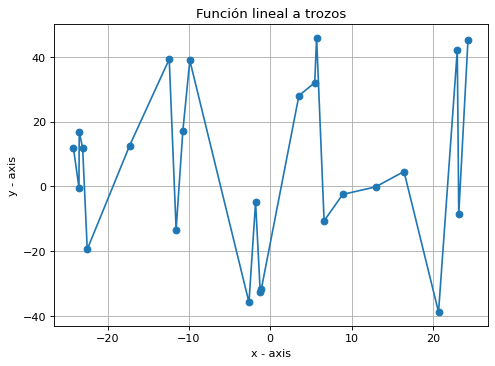

Original vertices:  [(-24.192170751969822, 11.82753117849441), (-23.51413819153121, -0.4157852289886321), (-23.481335952518588, 16.797792482724574), (-23.06175439737215, 11.843620485417503), (-22.496382625357707, -19.471185834390813), (-17.281171042545594, 12.586869390721432), (-12.416084024636948, 39.279112171253814), (-11.569759564035104, -13.369431719996562), (-10.737935342662542, 17.22549322351493), (-9.885053218146211, 38.88820973852296), (-2.61224878860914, -35.84578678230653), (-1.7991839884972656, -4.844360409182414), (-1.2291024575008365, -32.578263701923944), (-1.0826269236828168, -31.61156129247069), (3.5298250456031646, 28.004394590818478), (5.474958720065782, 31.998410086158657), (5.703502798217141, 45.96263417397137), (6.623589860634471, -10.685569544158135), (8.913353688133505, -2.503332088485081), (12.955434203473274, -0.18637962289798082), (16.447618600252788, 4.566382190432293), (20.694833185477634, -38.84356594949983), (22.998959318294354, 42.0039137340181), (23.1797

In [4]:
n = np.random.randint(10,30) # number of vertices in piecewise linear function
print('Number of vertices: ', n)
x = []
y = []

for i in range(0,n):
  k = random.uniform(-n,n) # random number between -n and n (x-component)
  l = random.uniform(-2*n,2*n) # random number between -2n and 2n (y-component)
  x.append(k)
  y.append(l)

x.sort() # sort x-components

plt.figure(figsize=(7,5),dpi=80)
plt.plot(x, y,marker='o')
plt.xlabel('x - axis') 
plt.ylabel('y - axis')
plt.title('Función lineal a trozos') #Original piecewise linear signal
plt.grid(b = True)
plt.show()
print('Original vertices: ', list(zip(x,y)))

--- 0.0012378692626953125 seconds ---


<ipython-input-5-b5373e41d2bb>:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b = True)


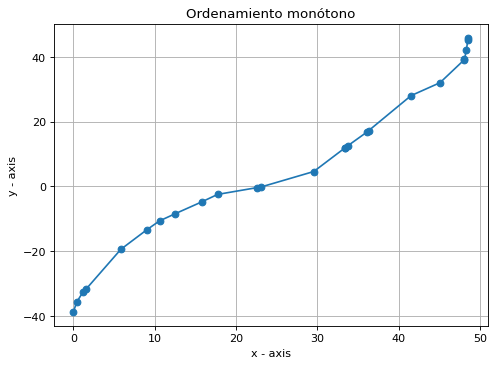

Ordered vertices:  [(0, -38.84356594949983), (0.3787373994625689, -35.84578678230653), (1.1952322530200132, -32.578263701923944), (1.6031401717527778, -31.61156129247069), (5.825644289725771, -19.471185834390813), (9.05067391855143, -13.369431719996562), (10.585318884846195, -10.685569544158135), (12.47754283392887, -8.505317992125718), (15.745322268441912, -4.844360409182414), (17.725411505872437, -2.503332088485081), (22.54877690242634, -0.4157852289886321), (23.091969862593352, -0.18637962289798082), (29.54636065897011, 4.566382190432293), (33.361516135684106, 11.82753117849441), (33.36907876224224, 11.843620485417503), (33.767964586315365, 12.586869390721432), (36.11035112820965, 16.797792482724574), (36.311227715248194, 17.22549322351493), (41.5050291969507, 28.004394590818478), (45.065660073680284, 31.998410086158657), (47.965203684923026, 38.88820973852296), (48.076282132216136, 39.279112171253814), (48.31011935187912, 42.0039137340181), (48.48791824849131, 45.31248245081582), (

In [5]:
#Rearrange and plot random function
start_time = time.time()
x_ast,y_ast,vec_meas = PL_Rearrangement(x,y)
print("--- %s seconds ---" % (time.time() - start_time)) # strat counting time


plt.figure(figsize=(7,5),dpi=80)
plt.plot(x_ast, y_ast,marker='o')
plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title('Ordenamiento monótono') # Ordered piecewise linear signal
plt.grid(b = True)
plt.show()

print('Ordered vertices: ', list(zip(x_ast,y_ast)))

In [ ]:
#verify rearrangement
max_difference,average_difference,std_difference = check_rearrangement(vec_meas,x_ast,y_ast)
print('The maximum distance is: ', max_difference)
print('The average max difference is: ', average_difference)
print('The std difference is: ', std_difference)

The maximum distance is:  8.881784197001252e-16
The average max difference is:  2.9605947323337506e-16
The std difference is:  4.1869132231567334e-16


#### **1.2.2 Verification protocol with 30 random signals**
Here we are going to generate 30 random signals, calculate their rearrangements and perform the verification. We compute the average and the maximum of the maximum difference of all the verifications.

In [ ]:
list_of_max_differences = []

print('Computing...\n')

n = 750

for i in range(15):
  #n = np.random.randint(10,50) # number of vertices in piecewise linear function
  x = []
  y = []

  for i in range(0,n):
    k = random.uniform(-n,n) # random number between -n and n (x-component)
    l = random.uniform(-2*n,2*n) # random number between -2n and 2n (y-component)
    x.append(k)
    y.append(l)

  x.sort()
  x_ast,y_ast,vec_meas = PL_Rearrangement(x,y) # rearrange random function
  max_difference, average_difference, std_difference = check_rearrangement(vec_meas,x_ast,y_ast) # compute maximum difference
  list_of_max_differences .append(max_difference) # append maximum difference

print('The average max difference is: ', mean(list_of_max_differences)) # prints average of maximum distances
print('The max of all max difference is: ', max(list_of_max_differences)) # prints average of maximum distances
print('The std of all max difference is: ', np.std(list_of_max_differences)) # prints average of maximum distances

Computing...

The average max difference is:  3.6333898852565955e-13
The max of all max difference is:  5.648814749292796e-13
The std of all max difference is:  7.515933454703644e-14


## **2. Operators of analog order filters and moving window**

The following algorithms will allow us to visualize the filtering by means of an analog rank order filter. We start with the window operator, then the evaluation functional and the filtering process; finally we generate a video showing the filtering.

### **2.1 Window operator**
The window operator receives a time $t$, a width $W$ and the $x$ and $y$ components of the original piecewise linear signal; it returns the vertices of the windowed signal centered at $t$ with width $W$. If the windowed signal admits a region in which the original signal is not defined, then zeros are added.

In [ ]:
def window(t,W,x,y):

  """
  Args:
    t: time to window
    W: width of thw window
    x: list of x-components of piecewise linear signal (ordered)
    y: list of corresponding y-components of piecewise linear signal
    
  Returns:
    x_window: list of x-components of windowed signal of the original signal at time t (ordered)
    y_window: list of y-components of windowed signal of the original signal at time t (ordered)
  """

  s = list(zip(x,y)) # Pairs like (x1,y1),(x2,y2),..,(xn,yn)
  L = W/2 # half the window lenght

  x_window = [t-L] # first x-component
  y_window = []

  # calculate the left vertex
  for v_1,v_2 in zip(s, s[1:]): # for each pair of consecutive vertices
    if (v_1[0] < t-L < v_2[0]): # if t-L is between two vertices
      m = (v_2[1]- v_1[1])/(v_2[0]-v_1[0]) # calculate slope
      b = v_1[1] - (m*v_1[0]) # calculate y-intercept
      y_window.append((m*(t-L)) + b) # add (m*(t-L)) + b to y_window
      break
    elif t-L == v_1[0]: # if t-L equals the x-component v_1[0]
      if v_1[0] == v_2[0]: # if there is a discontinuity
        y_window.append(v_2[1])
      else:
        y_window.append(v_1[1])
      break 
    elif t-L < s[0][0]: # if t-L is less than the first x-component of the signal
      y_window.append(0)
      if s[0][1] != 0:
        x_window.append(s[0][0])
        y_window.append(0)
      break

  # add in between vertices
  for v in zip(x,y): # for each vertex
    if t-L<v[0]<t+L: # if x-component is in between t-L and t+L
      x_window.append(v[0]) # add x-component
      y_window.append(v[1]) # add y-component
    else:
      continue

  # calculate the right vertex
  for v_1,v_2 in zip(s, s[1:]): # for each pair of consecutive vertices
    if (v_1[0] < t+L < v_2[0]): #if t+L is between two vertices
      m = (v_2[1]- v_1[1])/(v_2[0]-v_1[0]) # calculate slope
      b = v_1[1] - (m*v_1[0]) # calculate y-intercept
      y_window.append((m*(t+L)) + b) # add (m*(t+L)) + b to y_window
      x_window.append(t+L) # add x-component t+L
      break
    elif t+L == v_2[0]: # if t+L equals the x-component v_1[0]
      y_window.append(v_2[1]) # add the y-component of v_2
      x_window.append(t+L) # add x-component t+L
      #if v_1[0] == v_2[0]:
       # x_window.append(v_2[0])
        #y_window.append(v_2[1])
      #else:
      break
    elif t+L > s[-1][0]: #if t+L is bigger than the last x-component of the signal
      if s[-1][1] != 0:
        x_window.append(s[-1][0])
        y_window.append(0)
        x_window.append(t+L)
        y_window.append(0)
      else:
        x_window.append(t+L)
        y_window.append(0)
      break

    else:
      continue

  return x_window,y_window

#### **2.1.1 Test window operator**
Here we test the window operator on input vertices of a piecewise linear function.

Enter the x-components ordered and separated by commas: 0,1,2,5,6,8,8,9,11,12,13,16
Enter the y-components corresponding to the x-components, separated by commas: -1,1,0,6,4,4.5,7,8,2,5,3,10
Enter time of window center: 7
Enter window length: 6


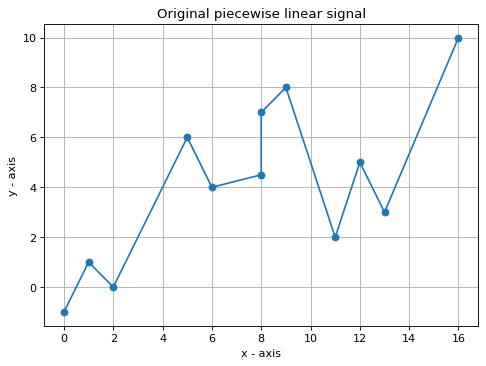

Original vertices:  [(0.0, -1.0), (1.0, 1.0), (2.0, 0.0), (5.0, 6.0), (6.0, 4.0), (8.0, 4.5), (8.0, 7.0), (9.0, 8.0), (11.0, 2.0), (12.0, 5.0), (13.0, 3.0), (16.0, 10.0)]


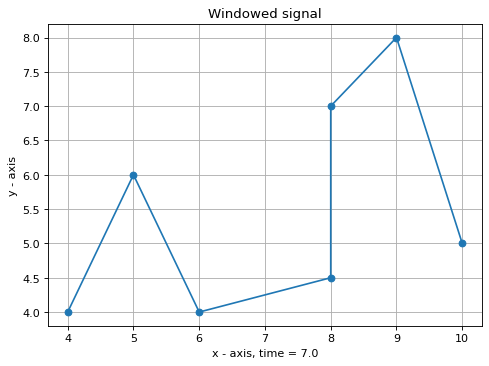

Windowed vertices:  [(4.0, 4.0), (5.0, 6.0), (6.0, 4.0), (8.0, 4.5), (8.0, 7.0), (9.0, 8.0), (10.0, 5.0)]


In [ ]:
x = np.array([float(i) for i in input('Enter the x-components ordered and separated by commas: ').split(',')])
x.sort()
y = np.array([float(i) for i in input('Enter the y-components corresponding to the x-components, separated by commas: ').split(',')])

t = float(input('Enter time of window center: ')) #4
W = float(input('Enter window length: ')) #18

plt.figure(figsize=(7,5),dpi=80)
plt.plot(x, y,marker='o')
plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title('Original piecewise linear signal')
plt.grid(b = True)
plt.show()
print('Original vertices: ', list(zip(x,y)))

x_window,y_window = window(t,W,x,y)

plt.figure(figsize=(7,5),dpi=80)
plt.plot(x_window, y_window, marker='o')
plt.xlabel(f'x - axis, time = {t}')
plt.ylabel('y - axis')
plt.title('Windowed signal')
plt.grid(b = True)
plt.show()
print('Windowed vertices: ', list(zip(x_window,y_window)))

### **2.2 Evaluation functional**
The evaluation functional $\delta$ receives a list of vertices that correspond to the rearrangement of a piecewise linear signal $f$; it also receives the point of evaluation $d$ in the interval; it returns the value of the rearrangement at that point, i.e., we compute $y_d:= f^{\ast}(d)$ for $d\in [0,\mu(I)]$.

In [ ]:
def evaluation_functional(x_ast,y_ast,d): 

  """
  Args:
    x_ast: list of x-components of the rearrangement signal (ordered)
    y_ast: list of corresponding y-components of the rearrangement signal
    d: point in the domain of the rearrangement to evaluate
    
  Returns:
    y_d: corresponding evaluation of the rearrangement at the point d
    v_1,v_2,v_3: vertices of the lines describing y_d
  """

  y_d = 0 # value of function at point d
  m_i = 0
  b_i = 0
  v_3 = None
  s = list(zip(x_ast,y_ast)) # list of vertices

  for v_1,v_2 in zip(s, s[1:]): # for each pair of consecutive vertices
    if v_1[0] == v_2[0] == d:  # the function is discontinuous at d
      y_d = v_1[1] # y_d takes the value corresponding to left continuity
      break

    elif v_1[0] < d < v_2[0]:  # if d is between two consecutive vertices
      m_i =  (v_2[1]-v_1[1])/(v_2[0]-v_1[0]) # calculate slope
      b_i = ((-m_i) * v_1[0]) + v_1[1] # calculate y-intercept
      y_d = (d*m_i) + b_i # compute y_d
      break

    elif (v_1[0] != v_2[0]) and ((v_1[0] == d) or ((v_2[0] == d))): # if d is an x-component of one vertex
      if (v_1[0] == d):
        y_d = v_1[1] # y_d takes the value of the y-component of v1
      elif (v_2[0] == d):
        y_d = v_2[1] # y_d takes the value of the y-component of v2
        for vg_2,vg_3 in zip(s, s[1:]):
          if vg_2 == v_2:
            v_3 = vg_3
            break
    else:
      continue

  return y_d,v_1,v_2,v_3

#### **2.2.1 Test evaluation functional**
Here you can test the evaluation functional with piecewise linear functions.

Enter the x-components ordered and separated by commas: 0,2,3,5,7,8,8,10
Enter the y-components corresponding to the x-components, separated by commas: 0,4,2,5,3,4.5,1,3


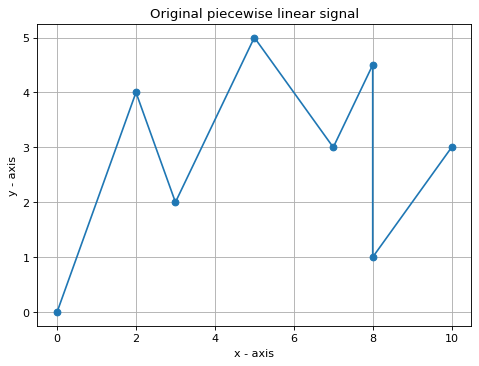

Original vertices:  [(0.0, 0.0), (2.0, 4.0), (3.0, 2.0), (5.0, 5.0), (7.0, 3.0), (8.0, 4.5), (8.0, 1.0), (10.0, 3.0)]


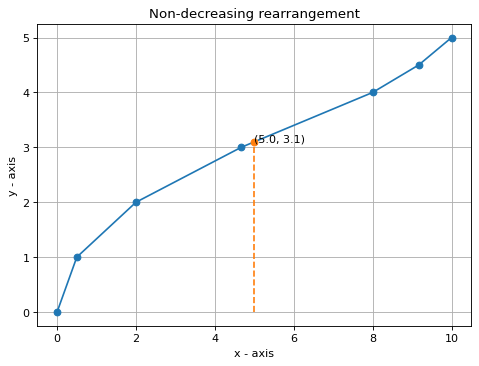

Ordered vertices:  [(0, 0.0), (0.5, 1.0), (2.0, 2.0), (4.666666666666666, 3.0), (8.0, 4.0), (9.166666666666668, 4.5), (10.0, 5.0)]
Evaluation y_d:  3.1


In [ ]:
x = np.array([float(i) for i in input('Enter the x-components ordered and separated by commas: ').split(',')])
x.sort()
y = np.array([float(i) for i in input('Enter the y-components corresponding to the x-components, separated by commas: ').split(',')])

plt.figure(figsize=(7,5),dpi=80)
plt.plot(x, y,marker='o')
plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title('Original piecewise linear signal')
plt.grid(b = True)
plt.show()
print('Original vertices: ', list(zip(x,y)))

x_ast,y_ast,vec_meas = PL_Rearrangement(x,y)

d = (x_ast[-1]-x_ast[0])/2
y_d,v_1,v_2,v_3 = evaluation_functional(x_ast,y_ast,d)

# plot the marker 
pointx = [d,d]
pointy = [min(y_ast),round(y_d,4)]
plt.figure(figsize=(7,5),dpi=80)
plt.plot(x_ast, y_ast,marker="o",label = "Non-decreasing rearrangement")

markers_on = [1]
plt.plot(pointx,pointy,marker="o", label = 'median', markevery=markers_on,linestyle='dashed')
plt.text(pointx[0],pointy[1],'({}, {})'.format(pointx[0],pointy[1]))
plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title('Non-decreasing rearrangement')
plt.grid(b = True)
plt.show()
print('Ordered vertices: ', list(zip(x_ast,y_ast)))
print('Evaluation y_d: ', y_d)

### **2.3 Moving window filter**
We now proceed to filter piecewise linear signals by window shift with the function *MovingWindowFilter*. The function receives the width $W$, the point of evaluation $d$ and the $x$ and $y$ components of the original signal. At first, we perform a shift of 0.01. Note that the output will depend directly on the shift since theoretically this should be continuous. We also present some video examples of the filtering process

In [ ]:
def MovingWindowFilter(W,d,x,y):

  """
  Args:
    W: width of the window
    d: point of evaluation
    x: list of x-components of piecewise linear signal (ordered)
    y: list of corresponding y-components of piecewise linear signal
    
  Returns:
    x_out: list of x-components of the filtered piecewise linear signal (ordered)
    y_out: list of y-components of the filtered piecewise linear signal (ordered)
  """

  t = x[0] #initial point
  i = 0
  x_out = []
  y_out = []

  epsilon = 0.01 # amount by which the window is moving, you can change this value and get a faster result but maybe not as accurate

  # rearrange and evaluate as the window is moving
  while t <= x[-1] + epsilon: 

    x_window,y_window = window(t,W,x,y)
    x_astW,y_astW,vec_meas = PL_Rearrangement(x_window,y_window)
    y_d,v_1,v_2,v_3 = evaluation_functional(x_astW,y_astW,d)

    y_out.append(y_d)
    x_out.append(t) 

    t += epsilon

  return x_out,y_out

#### **2.3.1 Test moving window filter**
Here you can test the moving-window algorithm for piecewise linear signals:

Enter the x-components ordered and separated by commas: -4,-2,0,3,5,8
Enter the y-components corresponding to the x-components, separated by commas: 0,2,1,4,1.5,6


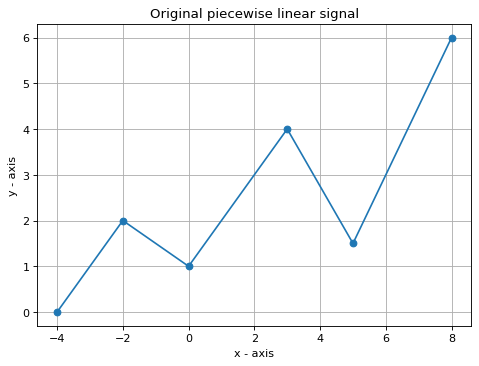

Original vertices:  [(-4.0, 0.0), (-2.0, 2.0), (0.0, 1.0), (3.0, 4.0), (5.0, 1.5), (8.0, 6.0)]
Enter the width of the window: 3
Enter the point of evaluation: 1.5
Computing...



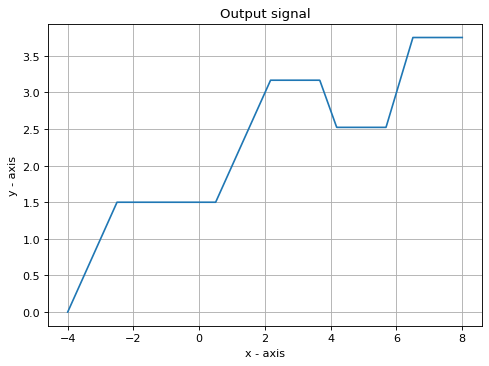

In [ ]:
x = np.array([float(i) for i in input('Enter the x-components ordered and separated by commas: ').split(',')])
x.sort()
y = np.array([float(i) for i in input('Enter the y-components corresponding to the x-components, separated by commas: ').split(',')])

plt.figure(figsize=(7,5),dpi=80)
plt.plot(x, y,marker='o')
plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title('Original piecewise linear signal')
plt.grid(b = True)
plt.show()
print('Original vertices: ', list(zip(x,y)))

W = float(input('Enter the width of the window: '))
d = float(input('Enter the point of evaluation: '))

print('Computing...\n')

x_out, y_out = MovingWindowFilter(W,d,x,y)

del x_out[-1]
del y_out[-1]

plt.figure(figsize=(7,5),dpi=80)
plt.plot(x_out, y_out)
plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title('Output signal')
plt.grid(b = True)
plt.show()

For the test with random signals you can run the following cell. Once the random signal is generated, you will be asked to enter the window width and the evaluation point.

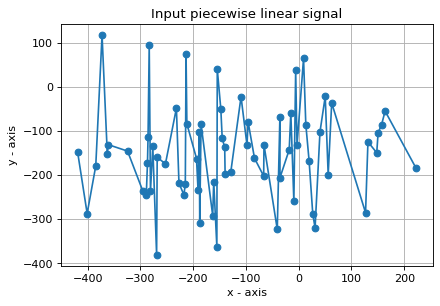

Original vertices:  [(-418.9032286077879, -148.4526037593285), (-400.8564939247548, -287.614037408459), (-384.56291733754574, -179.75684833148244), (-372.6406642892639, 116.97454433790662), (-362.6846789069782, -152.0489536498854), (-360.77489704453546, -131.44590399033316), (-324.30172457655385, -146.0443466160427), (-295.1280489584377, -237.27863529423234), (-288.83258957569353, -246.39917805557366), (-286.57690890293145, -173.79237538088591), (-285.45702588024983, -113.1140766922174), (-283.2479973218643, 93.91008743119212), (-280.88952886181335, -237.1078173404686), (-276.5008669847847, -135.43084607226928), (-269.2372758887373, -381.2576365334371), (-268.1315941138687, -159.873798650553), (-252.5211560045937, -175.05568204812977), (-231.72863303504383, -48.611803501327444), (-226.91565855986056, -218.70325821329033), (-217.58242926621688, -245.09603019475844), (-214.86437926705395, -221.41634365820335), (-213.46270919299133, 74.27633078110344), (-211.88624305655816, -84.0882434689

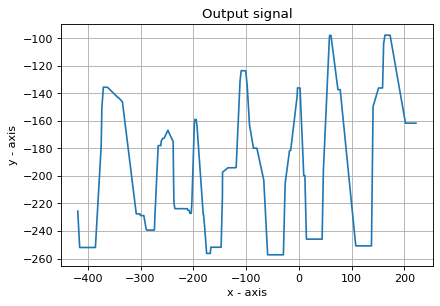

In [ ]:
n = np.random.randint(0,100) # number of vertices in piecewise linear function
x = []
y = []

for i in range(0,n):
  k = random.gauss(-2*n,2*n) # random number between -n and n (x-component)
  l = random.gauss(-2*n,2*n) # random number between -2n and 2n (y-component)
  x.append(k)
  y.append(l)

x.sort()

plt.figure(figsize=(6,4),dpi=80)
plt.plot(x,y,marker='o')
plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title('Input piecewise linear signal')
plt.grid(b = True)
plt.show()
print('Original vertices: ', list(zip(x,y)))

W = float(input('Enter the width of the window: '))
d = float(input('Enter the point of evaluation: '))
print('Computing...\n')

x_out, y_out = MovingWindowFilter(W,d,x,y)
plt.figure(figsize=(6,4),dpi=80)
plt.plot(x_out, y_out)
plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title('Output signal')
plt.grid(b = True)
plt.show()

#### **2.3.2 Filtering video examples**
In the following cells you will be able to see video examples of the filtering process of some signals. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from IPython.display import HTML
from base64 import b64encode
 
def show_video(video_path, video_width = 800):
   
  video_file = open(video_path, "r+b").read()
 
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")
 
show_video('/content/drive/MyDrive/AOF-Videos/senal3.mp4')

### **2.4 Moving average**
For comparison, the moving window algorithm of the moving average filter is presented below. Recall that for a given signal $f\colon I\to \mathbb{R}$ the output of a moving average filter with width $W$ is given by: $$\overline{f}(t):= \frac{1}{W}\int_{\frac{-W}{2}}^{\frac{W}{2}}f(t+\tau)\: d\tau$$

In [ ]:
def moving_average(W,x,y):

  """
  Args:
    W: width of the window
    x: list of x-components of piecewise linear signal (ordered)
    y: list of corresponding y-components of piecewise linear signal
    
  Returns:
    x_out: list of x-components of the filtered piecewise linear signal (ordered)
    y_out: list of y-components of the filtered piecewise linear signal (ordered)
  """

  t = x[0] #initial point
  i = 0
  x_out = []
  y_out = []

  epsilon = 0.01 # amount by which the window is moving, you can change this value and get a faster result but maybe not as accurate

  while t <= x[-1] + epsilon:
    x_window,y_window = window(t,W,x,y)
    x_astW,y_astW,vec_meas = PL_Rearrangement(x_window,y_window)
    y_d = np.sum(np.diff(x_astW) * (y_astW[:-1] + np.diff(y_astW)/2))
    x_out.append(t) 
    y_out.append(y_d)
    t += epsilon

  return x_out, y_out

Test the average filter algorithm with piecewise linear signals:

Enter the x-components ordered and separated by commas: -4,-2,0,3,5,8
Enter the y-components corresponding to the x-components, separated by commas: 0,2,1,4,1.5,6


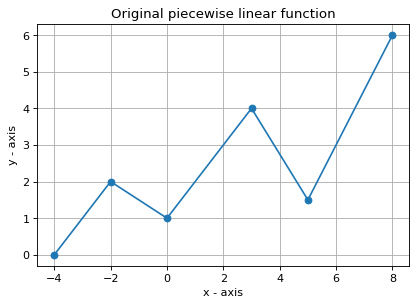

Original vertices:  [(-4.0, 0.0), (-2.0, 2.0), (0.0, 1.0), (3.0, 4.0), (5.0, 1.5), (8.0, 6.0)]
Enter the width of the window: 1
Computing...



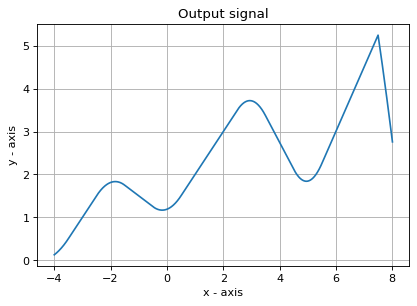

In [ ]:
x = np.array([float(i) for i in input('Enter the x-components ordered and separated by commas: ').split(',')])
x.sort()
y = np.array([float(i) for i in input('Enter the y-components corresponding to the x-components, separated by commas: ').split(',')])

plt.figure(figsize=(6,4),dpi=80)
plt.plot(x, y,marker='o')
plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title('Original piecewise linear function')
plt.grid(b = True)
plt.show()
print('Original vertices: ', list(zip(x,y)))

W = float(input('Enter the width of the window: '))

print('Computing...\n')

x_out, y_out = moving_average(W,x,y)
plt.figure(figsize=(6,4),dpi=80)
plt.plot(x_out, y_out)
plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title('Output signal')
plt.grid(b = True)
plt.show()


## **3. Algorithm for analog rank order filters by vertex calculation**
We now present a more efficient algorithm for the computation of the ouput signal of an analog rank order filter given a piecewise linear input. We use the fact that the output will also be piecewise linear. The algorithm will only compute the output vertices; for this purpose we developed the following methods:


1. *Distance to next slope*
2. *Next milestone arrangement*
3. *Check discontinuity*



### **3.1 Distance to next slope**
Given a windowed signal at a time $t$, the following algorithm calculates the distance $\Delta t$ for the signal windowed at the new time $t+\Delta t$ to reach a new slope at the ends of the window. The method returns the maximum distance together with the lines at the ends.

In [ ]:
def distance_next_slope(x_window,y_window,t,x,y):
  
  """
  Args:
    x_window: list of x-components of windowed signal of the original signal at time t (ordered)
    y_window: list of y-components of windowed signal of the original signal at time t (ordered)
    t: central time of the window
    
  Returns:
    max_distance: distance to next slope (maximum distance that the window has to move until the next slope); also return the slopes of the right and left vertexs
  """

  Vertices = list(zip(x,y))

  # left and right vertexs
  x_r = x_window[-1]
  x_l = x_window[0]
  y_r = y_window[-1]
  y_l = y_window[0]

  # if the right vertex of the window is less than the final vertex of the signal
  if  x[-1] <= x_r: 
    m_r =  0
    b_r = 0
    distance_right = (x[-1] + (x_window[-1]-x_window[0])/2) - x_r # compute distance to the right

  else: # computes the distance to the right by obtaining the line on which x_r lies (taking into account discontinuities)
    for v_1,v_2 in zip(Vertices, Vertices[1:]):
      if v_1[0] < x_r < v_2[0]:
        m_r =  (v_2[1]-v_1[1])/(v_2[0]-v_1[0])
        b_r = ((-m_r) * v_1[0]) + v_1[1]
        distance_right = v_2[0]-x_r
        break
      elif isclose(x_r, v_1[0], abs_tol=1e-8):
        if isclose(v_2[0], v_1[0], abs_tol=1e-8):
          for vdis_1,vdis_2 in zip(Vertices, Vertices[1:]):
            if (vdis_1 == v_2) and (vdis_2[0]!=v_2[0]):
              m_r =  (vdis_2[1]-v_2[1])/(vdis_2[0]-v_2[0])
              b_r = ((-m_r) * v_2[0]) + v_2[1] 
              distance_right = vdis_2[0]-v_2[0]
        else:
          m_r =  (v_2[1]-v_1[1])/(v_2[0]-v_1[0])
          b_r = ((-m_r) * v_1[0]) + v_1[1] 
          distance_right = v_2[0]-x_r
        break

  if x_l < x[0]:
    m_l =  0
    b_l = 0
    distance_left = x[0]-x_l
  else:
    for v_1,v_2 in zip(Vertices, Vertices[1:]):
      if v_1[0] < x_l < v_2[0]:
        m_l =  (v_2[1]-v_1[1])/(v_2[0]-v_1[0])
        b_l = ((-m_l) * v_1[0]) + v_1[1]
        distance_left = v_2[0]-x_l
        break
      elif x_l == v_1[0]: 
        if v_1[0] == v_2[0]:
          for vdis_1,vdis_2 in zip(Vertices, Vertices[1:]):
            if vdis_1 == v_2:
              m_l =  (vdis_2[1]-v_2[1])/(vdis_2[0]-v_2[0])
              b_l = ((-m_l) * v_2[0]) + v_2[1] 
              distance_left = vdis_2[0]-v_2[0]
        else:
          m_l =  (v_2[1]-v_1[1])/(v_2[0]-v_1[0])
          b_l = ((-m_l) * v_1[0]) + v_1[1]
          distance_left = v_2[0]-x_l
        break
  
  max_distance = min(distance_right,distance_left)

  return max_distance,m_r,m_l,b_r,b_l,distance_right,distance_left

### **3.2 Next milestone**
A windowed signal $f_{t}$ with vertices $\{(x_{i}^{t}, y_{i}^{t})\}$ is called a **milestone** if one of the following holds:

*   $y_{l}^{t} = y_{r}^{t}$, or
*   for some $i$, $y_{r}^{t} = y_{i}^{t}$, where $y_{i}^{t}$ is one of the levels where the slope changes, or
* for some $i$, $y_{l}^{t} = y_{i}^{t}$, where $y_{i}^{t}$ is one of the levels where the slope changes.

If for interval we have $y_{l}^{t} = y_{r}^{t}$, the times in the interval will not be taken as milestones.
The next algorithm computes the possible milestones (intersections) up until the maximum distance.




In [ ]:
def compute_next_intersection(max_distance,x_window,y_window,m_r,m_l,b_r,b_l,t,distance_right,distance_left,x,y):

  """
  Args:
    max_distance: distance to next slop
    x_window: list of x-components of windowed signal of the original signal at time t (ordered)
    y_window: list of y-components of windowed signal of the original signal at time t (ordered)
    m_r,m_l,b_r,b_l,t: current time and lines at the ends of the window
    distance_right,distance_left: distance to next slope from de right and from de left
    
  Returns:
    intersections: list with next milestones up to the maximum distance (distance next slope)
  """

  Vertices = list(zip(x,y))
  inside_levels = y_window.copy()
  inside_levels.pop(-1)
  inside_levels.pop(0)

  intersections = []

 # Compute possible inside intersections
  if m_l != 0:
    for y_w in inside_levels:
      x_intersection = (y_w - b_l)/(m_l)
      if x_window[0] < x_intersection <= x_window[0] + max_distance:
        intersections.append(x_intersection + (x_window[-1]-x_window[0])/2)
      else:
        continue
  elif m_l == 0:
    if distance_left == max_distance:
      intersections.append( t + distance_left)

  if m_r != 0:
    for y_w in inside_levels:
      x_intersection = (y_w - b_r)/(m_r)
      if x_window[-1] < x_intersection <= x_window[-1] + max_distance:
        intersections.append(x_intersection - (x_window[-1]-x_window[0])/2)
      else:
        continue
  elif m_r == 0:
    if distance_right == max_distance:
      intersections.append( t + distance_left)

  # Compute possible outside intersections
  if m_r != m_l :
    x_intersection = (m_r*(x_window[-1]-x_window[0]) + b_r - b_l)/(m_l - m_r)
    if x_window[0] < x_intersection <= x_window[0] + max_distance:
          intersections.append(x_intersection + (x_window[-1]-x_window[0])/2)

  # List with unique intersection values other than the current time
  intersections = np.unique(intersections, axis=0)
  intersections.sort()

  for k in intersections:
    if isclose(k, t, abs_tol=1e-8):
      index_t = np.where(intersections == k)
      intersections = np.delete(intersections, index_t)
    elif k > x[-1]:
      index_out_range = np.where(intersections == k)
      intersections = np.delete(intersections, index_out_range)

  return intersections

### **3.3 Check discontinuity**
When a vertex is calculated, the following algorithm checks if a discontinuity occurs at that vertex; if it does, it adds the other vertex with the other value in the same time.


In [ ]:
def check_discontinuity(x_v,y_v,W,d,x,y,x_out,y_out):

  """
  Args:
    x_v,y_v: vertex computed
    W,d: width of the window and point of evaluation
    y_window: list of y-components of windowed signal of the original signal at time t (ordered)
    x,y,x_out,y_out: vertices of input signal and current output vertices 
  """
  
  x_window_disc,y_window_disc = window(x_v,W,x,y)
  x_astW_disc,y_astW_disc,vec_meas = PL_Rearrangement(x_window_disc,y_window_disc)
  rea_window = list(zip(x_astW_disc,y_astW_disc)) # list of vertices

  for v_1rea,v_2rea in zip(rea_window, rea_window[1:]): # for each pair of consecutive vertices
    if isclose(v_1rea[0], d, abs_tol=1e-5) and isclose(v_1rea[0], v_2rea[0], abs_tol=1e-5):
      if isclose(y_v, v_1rea[1], abs_tol=1e-5):
        x_out.append(x_v)
        y_out.append(v_2rea[1])
        break
      elif isclose(y_v, v_2rea[1], abs_tol=1e-5):
        x_out.append(x_v)
        y_out.append(v_1rea[1])
        break

### **3.4 Filter algorithm by vertex computation**
The following algorithm is mainly divided into two. First, it asks for the levels of the window ends; accordingly, it asks for the location of the rearrangement value at the evaluation point, i.e. $f^{\ast}_{t}(d)$, with respect to the window ends. With this, it can be determined whether this value will go up or down, and so we proceed to calculate the possible vertices and then, in case it exists, we choose the smallest one that does not exceed the maximum distance.

In [ ]:
def AnalogRankFilter(W,d,x,y):
  
  """
  Args:
    W: width of the window
    d: point of evaluation
    x: list of x-components of piecewise linear signal (ordered)
    y: list of corresponding y-components of piecewise linear signal
    
  Returns:
    x_out: list of x-components of the filtered piecewise linear signal (ordered)
    y_out: list of y-components of the filtered piecewise linear signal (ordered)
  """

  np.seterr('raise')
  x_out = []
  y_out = []

  epsilon = 1e-8
  t = x[0]
  x_final = x[-1]

  first = 1
  InOut = 0   # 0 for outside, 1 for inside
  no_vertex = 0

  # compute first windowed signal, rearrange, evalute and add
  x_window,y_window = window(t,W,x,y)
  x_astW,y_astW,vec_meas = PL_Rearrangement(x_window,y_window)
  y_d,v_1,v_2,v_3constant = evaluation_functional(x_astW,y_astW,d)
  x_out.append(t)
  y_out.append(y_d)
  
  if v_2[0]!=v_1[0]:
    current_slope = (v_2[1]-v_1[1])/(v_2[0]-v_1[0])
  else:
    current_slope = None
  
  current_outside_value = y_d

  while t < x_final:

    t = t + epsilon

    # compute the windowed signal at t, rearrange and compute y_d
    x_window,y_window = window(t,W,x,y)
    x_astW,y_astW,vec_meas = PL_Rearrangement(x_window,y_window)
    y_d,v_1,v_2,v_3constant = evaluation_functional(x_astW,y_astW,d)

    # if first == 1:
    #   x_out.append(t)
    #   y_out.append(y_d)
    #   first = 0
    
    # compute distance to the next slope and the next milestone arrangement if any
    max_distance,m_r,m_l,b_r,b_l,distance_right,distance_left = distance_next_slope(x_window,y_window,t,x,y)
    intersections = compute_next_intersection(max_distance,x_window,y_window,m_r,m_l,b_r,b_l,t,distance_right,distance_left,x,y)

    # if there is a next milestone, save it in t_int
    if len(intersections)>0:
      if intersections[0] <= t + max_distance + epsilon:
        t_int = intersections[0]
      else:
        t_int = t + max_distance
    else:
      t_int = t + max_distance

    
    #  First case: if the value y_d is decreasing
    
    if y_window[0]>y_window[-1]:
      if y_d > y_window[0]: # if the current value y_d is outside and up

        if InOut == 1: # if previously the value was inside the interval (y_window[-1], y_window[0])
          x_out.append(t)
          y_out.append(y_d)
          check_discontinuity(t,y_d,W,d,x,y,x_out,y_out)
          InOut = 0
        
        elif InOut == 0 and (y_d != current_outside_value):
          x_out.append(t)
          y_out.append(y_d)
          check_discontinuity(t,y_d,W,d,x,y,x_out,y_out)
          current_outside_value = y_d
        else:
          current_outside_value = y_d

        if (m_l > 0) and (v_1[1] == y_window[0]): # if the left slope is positive and the left vertex is precisely  y_window[0]
          x_s = (y_d - b_l)/m_l # compute point of intersection
          vertex = x_s + W/2 # compute time of vertex
          if t < vertex <= t_int + epsilon: # verify that the time is less than the next milestone
            t = vertex 
            x_out.append(vertex) # add vertex
            y_out.append(y_d)
            check_discontinuity(vertex,y_d,W,d,x,y,x_out,y_out)
            InOut = 1
          else: # if the time passes the next milestone, assing t= t_int
            t = t_int
            InOut = 0
        else: # if either ml <= 0 or v_1[1] != y_window[0] the move to the next milestone
          t = t_int
          InOut = 0
      
      elif y_d < y_window[-1]: # if the current value y_d is outside and down
        if InOut == 1:
          x_out.append(t)
          y_out.append(y_d)
          check_discontinuity(t,y_d,W,d,x,y,x_out,y_out)
          InOut = 0
        
        elif InOut == 0 and (y_d != current_outside_value):
          x_out.append(t)
          y_out.append(y_d)
          check_discontinuity(t,y_d,W,d,x,y,x_out,y_out)
          current_outside_value = y_d
        else:
          current_outside_value = y_d

        if (m_r < 0) and (v_2[1] == y_window[-1]): # if the right slope is positive and the right vertex is precisely  y_window[-1]
          x_s = (y_d - b_r)/m_r
          vertex = x_s - W/2
          if t < vertex <= t_int + epsilon:
            t = vertex
            x_out.append(vertex)
            y_out.append(y_d)
            check_discontinuity(vertex,y_d,W,d,x,y,x_out,y_out)
            InOut = 1
          else:
            t = t_int
            InOut = 0
        else:
          t = t_int
          InOut = 0
      
      elif y_window[-1] < y_d < y_window[0]: # if the current value y_d is inside
        possible_vertexs = [] # lists in which the possible vertices to be calculated will be stored.
        possible_heights = [] 
        if InOut == 0:
          x_out.append(t)
          y_out.append(y_d)
          check_discontinuity(t,y_d,W,d,x,y,x_out,y_out)
          InOut = 1
        elif InOut == 1: 
          if v_2[0]!=v_1[0]:
            if (current_slope != None):
              if (abs( (v_2[1]-v_1[1])/(v_2[0]-v_1[0]) - current_slope)  > 0.5): # If it was inside but the slope changed abruptly
                x_out.append(t)
                y_out.append(y_d)
                check_discontinuity(t,y_d,W,d,x,y,x_out,y_out)
                current_slope = (v_2[1]-v_1[1])/(v_2[0]-v_1[0])
              else:
                current_slope = (v_2[1]-v_1[1])/(v_2[0]-v_1[0])
            else:
                current_slope = (v_2[1]-v_1[1])/(v_2[0]-v_1[0])
        
        if v_1[1] == y_window[-1] and m_r>0: # If the possible vertex will be with the right vertex
          Vertices = list(zip(x,y))
          Move_epsilon = 0
          for vv_1,vv_2 in zip(Vertices, Vertices[1:]):
            if vv_1 == (x_window[-1],y_window[-1]): # if we get problems with right vertex
              Move_epsilon = 1
          
          if Move_epsilon == 1: # we move the window by epsilon so the we don't get the same vertex
            t = t + epsilon

          else:
            search = list(zip(x_astW,y_astW))
            for v_1wast,v_2wast in zip(search, search[1:]):
              if v_2wast == v_1:
                v_minus1 = v_1wast
                break
            # compute possible vertex
            if v_1[0]!=v_minus1[0]:
              m_prime = (v_1[1]-v_minus1[1])/(v_1[0]-v_minus1[0]) # no problem with dividing by cero beacuse the slope in this case is always positive
              b_prime = ((-m_prime) * v_1[0]) + v_1[1]
              y_ex = m_prime * d + b_prime

              x_ex = (y_ex - b_r)/m_r
              possible_vertexs.append(x_ex - W/2)
              possible_heights.append(y_ex)
        
        if v_1[1] == y_window[-1] and m_r == 0: # If the possible vertex will be with the right vertex but the right slope is 0
          dist = d - v_1[0]
          possible_vertexs.append(dist+t)
          possible_heights.append(v_1[1])
        
        if v_2[1] == y_window[0] and m_l<0: # If the possible vertex will be with the left vertex
          search = list(zip(x_astW,y_astW))
          
          if v_2 != (x_astW[-1],y_astW[-1]):
            for v_1wast,v_2wast in zip(search, search[1:]):
              if v_1wast == v_2:
                v_3 = v_2wast
                break
            # compute vertex
            if v_3[0]!=v_2[0] :
              m_prime = (v_3[1]-v_2[1])/(v_3[0]-v_2[0])
              b_prime = ((-m_prime) * v_2[0]) + v_2[1]
              y_ex = m_prime * d + b_prime

              x_ex = (y_ex - b_l)/m_l
              possible_vertexs.append(x_ex+ W/2)
              possible_heights.append(y_ex)
        
        if (v_1[1] != y_window[-1]) and (v_2[1] != v_1[1]): # if the vertex is not with the ends
          m_dd = (v_2[1]-v_1[1])/(v_2[0]-v_1[0])
          delta_x = (y_d-v_1[1])/(m_dd)
          possible_vertexs.append(t+delta_x)
          possible_heights.append(v_1[1])
        
        if v_1[1] == v_2[1]: # if it is in a constant segment
          dist = d - v_1[0]
          possible_vertexs.append(dist+t)
          possible_heights.append(v_1[1])
        
        if len(possible_vertexs)>0: # if any vertex was calculated
          for tau in possible_vertexs:
            if tau < t:
              possible_vertexs.remove(tau) # We are interested in those vertices that are greater than the time we are in

          vertex = min(possible_vertexs) # we take the minimum vertex
          min_index = int(possible_vertexs.index(vertex))
          if t < vertex <= t_int + epsilon:
            t = vertex
            x_out.append(vertex)
            y_out.append(possible_heights[min_index])
            check_discontinuity(vertex,possible_heights[min_index],W,d,x,y,x_out,y_out)
            InOut = 1
          else:
            t = t_int
            InOut = 1
        else:
          t = t_int
          InOut = 1
      
      elif v_1[1] == v_2[1]: # if it is in a constant segment
          if InOut == 0:
            x_out.append(t)
            y_out.append(y_d)
            check_discontinuity(t,y_d,W,d,x,y,x_out,y_out)

          if v_1 == (x_astW[0],y_astW[0]):
            t = t_int 
          else:
            dist = d - v_1[0]
            if t < t + dist <= t_int + epsilon:
              t = t + dist
              x_out.append(t)
              y_out.append(v_1[1])
              check_discontinuity(t,v_1[1],W,d,x,y,x_out,y_out)
              InOut = 1
            else:
              InOut = 0
              t = t_int
      
      else:
        InOut = 0
        t = t_int


    #  Second case: if the value y_d is increasing

    elif y_window[0]<y_window[-1]: 
      if y_d > y_window[-1]: # if the current value y_d is outside and up
        if InOut == 1:
          x_out.append(t)
          y_out.append(y_d)
          check_discontinuity(t,y_d,W,d,x,y,x_out,y_out)
          InOut = 0
          
        elif InOut == 0 and (y_d != current_outside_value):
          x_out.append(t)
          y_out.append(y_d)
          check_discontinuity(t,y_d,W,d,x,y,x_out,y_out)
          current_outside_value = y_d
        else:
          current_outside_value = y_d
        
        if (m_r > 0) and (v_1[1] == y_window[-1]): # if the right slope is positive and the left vertex is precisely  y_window[-1]
          # compute vertex
          x_s = (y_d - b_r)/m_r
          vertex = x_s - W/2
          if t < vertex <= t_int + epsilon: # if the time of the vertex is less than the next milestone
            t = vertex
            x_out.append(vertex)
            y_out.append(y_d)
            check_discontinuity(vertex,y_d,W,d,x,y,x_out,y_out)
            InOut = 1
          else:
            InOut = 0
            t = t_int
        else:
          t = t_int
          InOut = 0
      
      elif y_d < y_window[0]: # # if the current value y_d is outside and down
        if InOut == 1:
          x_out.append(t)
          y_out.append(y_d)
          check_discontinuity(t,y_d,W,d,x,y,x_out,y_out)
          InOut = 0
          
        elif InOut == 0 and (y_d != current_outside_value):
          x_out.append(t)
          y_out.append(y_d)
          check_discontinuity(t,y_d,W,d,x,y,x_out,y_out)
          current_outside_value = y_d
        else:
          current_outside_value = y_d

        if (m_l < 0) and (v_2[1] == y_window[0]): # if the left slope is negative and the right vertex is precisely  y_window[0]
          # compute vertex
          x_s = (y_d - b_l)/m_l
          vertex = x_s + W/2
          if t < vertex <= t_int + epsilon:
            t = vertex
            x_out.append(vertex)
            y_out.append(y_d)
            check_discontinuity(vertex,y_d,W,d,x,y,x_out,y_out)
            InOut = 1
          else:
            t = t_int
            InOut = 0
        else:
          t = t_int
          InOut = 0
      
      elif y_window[0] < y_d < y_window[-1]: # if the current value y_d is inside
        possible_vertexs = [] 
        possible_heights = []

        if InOut == 0:
          x_out.append(t)
          y_out.append(y_d)
          check_discontinuity(t,y_d,W,d,x,y,x_out,y_out)
          InOut = 1
        elif InOut == 1: 
          if v_2[0]!=v_1[0]:
            if (current_slope != None):
              if (abs( (v_2[1]-v_1[1])/(v_2[0]-v_1[0]) - current_slope)  > 0.5): # If it was inside but the slope changed abruptly
                x_out.append(t)
                y_out.append(y_d)
                check_discontinuity(t,y_d,W,d,x,y,x_out,y_out)
                current_slope = (v_2[1]-v_1[1])/(v_2[0]-v_1[0])
              else:
                current_slope = (v_2[1]-v_1[1])/(v_2[0]-v_1[0])
            else:
                current_slope = (v_2[1]-v_1[1])/(v_2[0]-v_1[0])

        if v_2[1] == y_window[-1] and m_r<0: # If the possible vertex will be with the right vertex
          Vertices = list(zip(x,y))
          Move_epsilon = 0
          for vv_1,vv_2 in zip(Vertices, Vertices[1:]):
            if vv_1 == (x_window[-1],y_window[-1]):
              Move_epsilon = 1
          
          if Move_epsilon == 1:
            t = t + epsilon
          else:
            search = list(zip(x_astW,y_astW))
            for v_1wast,v_2wast in zip(search, search[1:]):
              if v_1wast == v_2:
                v_3 = v_2wast
                break
            
            if v_3[0]!=v_2[0]:
              m_prime = (v_3[1]-v_2[1])/(v_3[0]-v_2[0])
              b_prime = ((-m_prime) * v_2[0]) + v_2[1]
              y_ex = m_prime * d + b_prime

              x_ex = (y_ex - b_r)/m_r
              possible_vertexs.append(x_ex - W/2)
              possible_heights.append(y_ex)
        
        if v_2[1] == y_window[-1] and m_r == 0: # If the possible vertex will be with the right vertex but the right slope is 0
          dist = v_2[0] - d
          possible_vertexs.append(dist+t)
          possible_heights.append(v_2[1])

        if v_1[1] == y_window[0] and m_l>0: # If the possible vertex will be with the left vertex
          search = list(zip(x_astW,y_astW))
          if v_1 == (x_astW[0],y_astW[0]):
            no_vertex = 0
            if v_2 == (x_astW[-1],y_astW[-1]):
              no_vertex = 1
          else:
            for v_1wast,v_2wast in zip(search, search[1:]):
              if v_2wast == v_1:
                v_minus1 = v_1wast
                break
            if v_1[0]!=v_minus1[0]:
              m_prime = (v_1[1]-v_minus1[1])/(v_1[0]-v_minus1[0])
              b_prime = ((-m_prime) * v_1[0]) + v_1[1]
              y_ex = m_prime * d + b_prime

              x_ex = (y_ex - b_l)/m_l
              possible_vertexs.append(x_ex + W/2)
              possible_heights.append(y_ex)
        
        if (v_2[1] != y_window[-1]) and (v_2[1]!=v_1[1]): # if the vertex is not with the ends
          m_dd = (v_2[1]-v_1[1])/(v_2[0]-v_1[0])
          delta_x = (v_2[1]-y_d)/(m_dd)
          possible_vertexs.append(t+delta_x)
          possible_heights.append(v_2[1])
        
        if v_1[1] == v_2[1]: # if it is in a constant segment
          dist = v_2[0] - d
          possible_vertexs.append(dist+t)
          possible_heights.append(v_2[1])

        if len(possible_vertexs)>0: # if any vertex was calculated
          vertex = min(possible_vertexs)
          min_index = int(possible_vertexs.index(vertex))
          if no_vertex == 0:
            if t < vertex <= t_int + epsilon:
              t = vertex
              x_out.append(vertex)
              y_out.append(possible_heights[min_index])
              check_discontinuity(vertex,possible_heights[min_index],W,d,x,y,x_out,y_out)
              InOut = 1
            else:
              t = t_int
              InOut = 1
          else:
            t = t_int
            InOu = 1
            no_vertex = 0
        else:
          t = t_int
          InOut = 1
      
      elif v_1[1] == v_2[1]: # if it is in a constant segment
        dist = v_2[0] - d
        if t < t + dist <= t_int + epsilon:
          t = t + dist
          x_out.append(t)
          y_out.append(v_2[1])
          check_discontinuity(t,v_2[1],W,d,x,y,x_out,y_out)
        else:
          InOut = 1
          current_slope = 0
          t = t_int
      else:
        t = t_int
        InOut = 0

    elif isclose(y_window[0], y_window[-1], abs_tol=1e-8) and (isclose(m_r, m_l, abs_tol=1e-8)): # if the ends have the same level
      if InOut == 1:
        x_out.append(t)
        y_out.append(y_d)
        check_discontinuity(t,y_d,W,d,x,y,x_out,y_out)
        InOut = 0
      t = t_int

    if t >= x_final-epsilon: # final omputation
      x_out.append(x_final) 
      x_window,y_window = window(x_final,W,x,y)
      x_astW,y_astW,vec_meas = PL_Rearrangement(x_window,y_window)
      y_d,v_1,v_2,v_3constant = evaluation_functional(x_astW,y_astW,d)
      y_out.append(y_d)
      check_discontinuity(x_final,y_d,W,d,x,y,x_out,y_out)
      break 

  return x_out,y_out

#### **3.4.1 Test filter algorithm**
Here you can test the filter algorithm for piecewise linear signals:

Enter the x-components ordered and separated by commas: -1,2,8,8,20,30,30,42,44
Enter the y-components corresponding to the x-components, separated by commas: 4,-12,6,-6,6,-6,12,-12,4


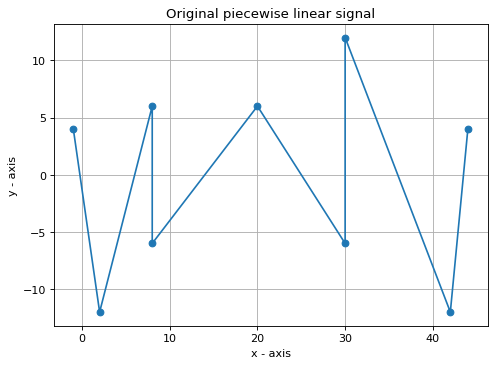

Original vertices:  [(-1.0, 4.0), (2.0, -12.0), (8.0, 6.0), (8.0, -6.0), (20.0, 6.0), (30.0, -6.0), (30.0, 12.0), (42.0, -12.0), (44.0, 4.0)]
Enter the width of the window: 5
Enter the point of evaluation: 1
Computing...



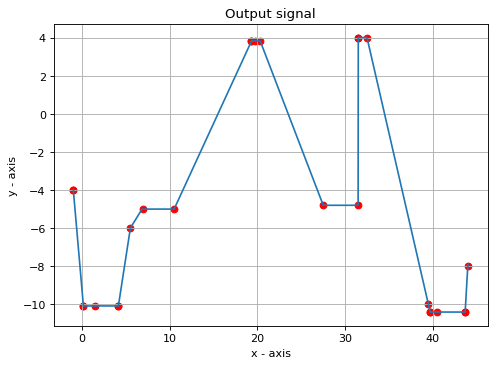

Output vertices:  [(-1.0, -3.999999999999999), (-0.99999, -4.000053333333333), (0.1399999999833259, -10.080000000050022), (0.14000999998332592, -10.08), (1.50001, -10.08), (4.14, -10.08), (4.140009999999999, -10.079970000000003), (5.50001, -5.9999925), (7.00001, -5.0), (10.50001, -4.99999), (19.31818181808395, 3.818181818299263), (19.31819181808395, 3.8181818181818183), (19.77273727272727, 3.818181818181819), (20.31818181818182, 3.818181818181819), (27.50001, -4.8), (31.5, -4.8), (31.5, 4.0), (31.50001, 3.999999999999993), (32.50001, 3.9999799999999937), (39.50001, -10.000020000000006), (39.7, -10.4), (39.700010000000006, -10.4), (40.50001, -10.4), (43.7, -10.4), (43.700010000000006, -10.399919999999923), (44.0, -8.0)]


In [ ]:
x = np.array([float(i) for i in input('Enter the x-components ordered and separated by commas: ').split(',')])
x.sort()
y = np.array([float(i) for i in input('Enter the y-components corresponding to the x-components, separated by commas: ').split(',')])

plt.figure(figsize=(7,5),dpi=80)
plt.plot(x, y,marker='o')
plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title('Original piecewise linear signal')
plt.grid(b = True)
plt.show()
print('Original vertices: ', list(zip(x,y)))

W = float(input('Enter the width of the window: '))
d = float(input('Enter the point of evaluation: '))

print('Computing...\n')

x_out, y_out = AnalogRankFilter(W,d,x,y)
x_out1, y_out1 = MovingWindowFilter(W,d,x,y)

plt.figure(figsize=(7,5),dpi=80)
plt.scatter(x_out, y_out,c="red")
plt.plot(x_out1,y_out1)
plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title('Output signal')
plt.grid(b = True)
plt.show()
print('Output vertices: ', list(zip(x_out,y_out)))

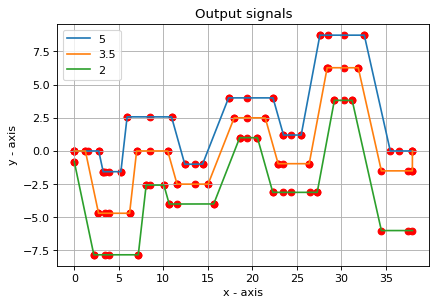

In [ ]:
x_out, y_out = AnalogRankFilter(7,3.5,x,y)
x_out1, y_out1 = MovingWindowFilter(7,3.5,x,y)
x_outA, y_outA = AnalogRankFilter(7,5,x,y)
x_out1A, y_out1A = MovingWindowFilter(7,5,x,y)
x_outB, y_outB = AnalogRankFilter(7,2,x,y)
x_out1B, y_out1B = MovingWindowFilter(7,2,x,y)

plt.figure(figsize=(6,4),dpi=80)

plt.scatter(x_outA, y_outA,c="red")
plt.plot(x_out1A,y_out1A,label="5")

plt.scatter(x_out, y_out,c="red")
plt.plot(x_out1,y_out1,label="3.5")

plt.scatter(x_outB, y_outB,c="red")
plt.plot(x_out1B,y_out1B,label="2")

plt.legend(loc="upper left")

plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title('Output signals')
plt.grid(b = True)
plt.show()

#### **3.4.2 Test protocol for filter algorithm**
In order to verify whether the filtered signal with the vertex computation algorithm resembles that of the moving window filter, the **uniform norm** will be implemented. Given a signal $f\colon I \to \mathbb{R}$, the uniform norm of $f$ is defined as: 
$$
||f||_{\infty}:= \sup_{x\in I}\: f(x).
$$
This norm induces a metric: if $g\colon I\to \mathbb{R}$ is another signal, then
$$
||f-g||_{\infty} \colon= \sup_{x\in I}\: f(x)-g(x)
$$
represents the distance between two signals in the uniform norm.

In principle we will not be able to make the evaluation for the whole domain $I$; however, we will sample the domain randomly and take the supremum of all these values. Note that this algorithm gives us an idea of the similarity between the two signals, but the convention in the discontinuities may affect the result; it is for this reason that one should not only verify with this method, but also integrate other handcrafted methods.

In [ ]:
def verify_filtered_signal(x_out,y_out,x_out1,y_out1, n_p):

  """
  Args:
   x_out,y_out : output vertices of algorithm by vertex computation 
   x_out1,you1: output vertices of moving window algorithm
   n_p: number of evaluation points
    
  Returns:
    max_difference_filter: maximum difference of values |f(x)-g(x)|
    average_difference_filter: average difference of values |f(x)-g(x)|
  """

  evaluations = []
  for i in range(n_p):
    k = np.random.randint(0,len(x_out1)-1) # un índice aleatorio entre 0 y len(x_out1)-1
    evaluations.append(k)

  set_difference = []
  Filtered_vertices = list(zip(x_out,y_out))

  for k in evaluations:
    g = y_out1[k]
    q = x_out1[k]
    for vg_1,vg_2 in zip(Filtered_vertices, Filtered_vertices[1:]): # for each pair of consecutive vertices
        if vg_1[0] == vg_2[0] == q:  # the function is discontinuous at d
          f = vg_1[1] # y_d takes the value corresponding to left continuity
          break

        elif vg_1[0] < q < vg_2[0]:  # if d is between two consecutive vertices
          Dm_i =  (vg_2[1]-vg_1[1])/(vg_2[0]-vg_1[0]) # calculate slope
          Db_i = ((-Dm_i) * vg_1[0]) + vg_1[1] # calculate y-intercept
          f = (q*Dm_i) + Db_i # compute y_d
          break

        elif (vg_1[0] != vg_2[0]) and ((vg_1[0] == q) or ((vg_2[0] == q))): # if d is an x-component of one vertex
          if (vg_1[0] == q):
            f = vg_1[1] # y_d takes the value of the y-component of v1
          elif (vg_2[0] == q):
            f = vg_2[1] # y_d takes the value of the y-component of v2
            for vc_2,vc_3 in zip(Filtered_vertices, Filtered_vertices[1:]):
              if vc_2 == vg_2:
                vg_3 = vc_3
                break
        else:
          continue
    
    set_difference.append(abs(g-f))

  max_difference_filter = max(set_difference)
  average_difference_filter = mean(set_difference)
  std_difference_filter = np.std(set_difference)
  return max_difference_filter, average_difference_filter,std_difference_filter

For the test with random signals you can run the following cell. Once the random signal is generated, you will be asked to enter the window width and the evaluation point.

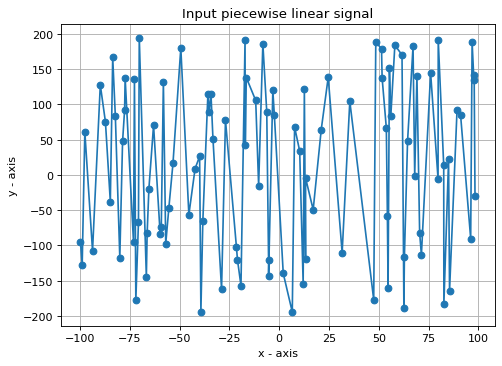

Original vertices:  [(-99.75310848381076, -94.88960415227146), (-98.8762676818158, -127.32136391923197), (-97.55822301216823, 61.322116043935864), (-93.68879959614576, -107.58880287241466), (-89.78677126818036, 127.71584620227867), (-87.21106563578628, 75.23607627186254), (-84.75958961912264, -37.720687347582725), (-83.56273012259909, 166.75344870654737), (-82.23134629045283, 83.05260630379377), (-79.9977219678492, -117.18215057319989), (-78.61033188407532, 47.60110484086749), (-77.59061884139236, 92.21192911364955), (-77.32019624653626, 137.750659858649), (-73.12264984127253, -95.60180271776275), (-72.64603156106153, 135.56552083329115), (-71.95468631437767, -177.66737397162896), (-70.63325866707721, -67.00012603369822), (-70.22738918719777, 195.0330821769732), (-66.67136420449755, -144.98477605863008), (-66.27157344199284, -82.57121274027352), (-65.39446017513654, -19.439612583925395), (-63.05756236895799, 70.48347648429979), (-59.74190596060913, -83.77199390570298), (-59.17629046146

In [ ]:
n = np.random.randint(1,120) # number of vertices in piecewise linear function
x = []
y = []

for i in range(0,n):
  k = random.uniform(-n,n) # random number between -n and n (x-component)
  l = random.uniform(-2*n,2*n) # random number between -2n and 2n (y-component)
  x.append(k)
  y.append(l)

x.sort()

plt.figure(figsize=(7,5),dpi=80)
plt.plot(x,y,marker='o')
plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title('Input piecewise linear signal')
plt.grid(b = True)
plt.show()
print('Original vertices: ', list(zip(x,y)))

Enter the width of the window: 200
Enter the point of evaluation: 150
Computing...

--- 23.457520246505737 seconds algo 1 ---
--- 113.27077007293701 seconds algo 2 ---


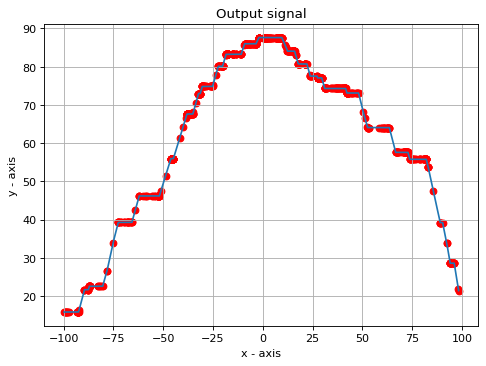

Output vertices:  [(-99.75310848381076, 15.825416931153484), (-99.2735414505667, 15.82541693115337), (-99.0701152136057, 15.825416931153484), (-98.69147932175444, 15.82541693115337), (-98.59643628620682, 15.825416931153484), (-98.40563966624721, 15.82541693115337), (-98.34087765471597, 15.825416931153484), (-97.63960394322696, 15.82541693115337), (-97.51350112887542, 15.825416931153484), (-93.25816988293427, 15.82541693115337), (-93.2052293876052, 15.825416931153484), (-92.98455051553962, 15.82541693115337), (-92.93557530304084, 15.825416931153484), (-92.9302856309407, 15.82541693115337), (-92.86169199765274, 15.825416931153484), (-92.85478317395062, 15.82541693115337), (-92.81441069711288, 15.825416931153484), (-92.65217878383298, 15.82541693115337), (-92.56654354963453, 15.825416931153484), (-92.52764626533123, 15.825416931153597), (-92.49682955276651, 15.825416931153597), (-92.2456949521139, 16.321505421852038), (-89.5897458229967, 21.66010578463289), (-89.58974581299671, 21.6601062

In [ ]:
W = float(input('Enter the width of the window: '))
d = float(input('Enter the point of evaluation: '))
print('Computing...\n')

start_time = time.time()
x_out, y_out = AnalogRankFilter(W,d,x,y)
print("--- %s seconds algo 1 ---" % (time.time() - start_time)) # strat counting time

start_time = time.time()
x_out1, y_out1 = MovingWindowFilter(W,d,x,y)
print("--- %s seconds algo 2 ---" % (time.time() - start_time)) # strat counting time

plt.figure(figsize=(7,5),dpi=80)
plt.scatter(x_out, y_out,c="red")
plt.plot(x_out1,y_out1)
plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title('Output signal')
plt.grid(b = True)
plt.show()
print('Output vertices: ', list(zip(x_out,y_out)))

In [ ]:
n_p = np.random.randint(0.5*len(x_out1),len(x_out1)) # number of evaluation points
print('Número de evaluaciones: ',n_p)
max_difference_filter, average_difference_filter,std_difference_filter = verify_filtered_signal(x_out,y_out,x_out1,y_out1, n_p)
print('Maximum difference between evaluation points: ', max_difference_filter)
print('average difference between evaluation points: ', average_difference_filter)
print('std difference between evaluation points: ', std_difference_filter)

Número de evaluaciones:  19105
Maximum difference between evaluation points:  1.4727133077485632e-06
average difference between evaluation points:  3.5973489011197465e-08
std difference between evaluation points:  1.524494885982084e-07


**Verification protocol with 30 random signals**: here we are going to generate 30 random signals, calculate their filtered outputs and perform the verification. We compute the average and the maximum of the maximum difference of all the verifications, given a fixed window width and evaluation point.

In [ ]:
max_difference_list = []
W = float(input('Enter the width of the window: '))
d = float(input('Enter the point of evaluation: '))

m =  #np.random.randint(10,50) # number of vertices in piecewise linear function

print('Computing...\n')
for i in range(15):
  
  x = []
  y = []

  for i in range(0,m):
    k = random.gauss(-m,m) # random number between -n and n (x-component)
    l = random.gauss(-2*m,2*m) # random number between -2n and 2n (y-component)
    x.append(k)
    y.append(l)

  x.sort()

  x_out, y_out = AnalogRankFilter(W,d,x,y)
  x_out1, y_out1 = MovingWindowFilter(W,d,x,y)

  n = np.random.randint(0.5*len(x_out1),len(x_out1)) # number of evaluations

  max_difference_filtered = verify_filtered_signal(x_out,y_out,x_out1,y_out1, n)
  max_difference_list.append(max_difference_filtered) 

print('The average of all max differences is: ', mean(max_difference_list))
print('The maximum of all max differences is: ', max(max_difference_list))

Enter the width of the window: 10
Enter the point of evaluation: 5
Computing...

The average of all max differences is:  3.5285676208474115e-05
The maximum of all max differences is:  0.00017518295538820894
